# Analisis Sentimen Ulasan Aplikasi Netflix di Google Playstore

M. Zidan Richal Fajril Falah

## Install Library

In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


## Import Library

In [2]:
# Mengimpor library yang dibutuhkan untuk scraping, pemrosesan data, dan pemodelan machine learning

# Library Umum Python dan Utilitas
import re
import string
import csv
import requests
from io import StringIO
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Library Natural Language Processing (NLP) - Umum
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Library NLP Bahasa Indonesia (Sastrawi)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Library Machine Learning dan Deep Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Mengunduh sumber daya NLTK yang dibutuhkan
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Loading

In [3]:
df = pd.read_csv('ulasan_netflix.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,31d8b18f-13f1-4cb7-82d5-72c91630a64a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi nya udh bagus sihh, tapi kenapa akhir...",3,4,9.16.0 build 6 62648,2025-05-24 06:22:51,NaN,NaN,9.16.0 build 6 62648
1,bd681728-a41f-4775-a6fb-7f30773d5ec3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"daftar netflix tgl 22 klo ngga salah, eh saldo...",3,1,9.16.0 build 6 62648,2025-05-26 02:01:24,NaN,NaN,9.16.0 build 6 62648
2,b08b3610-da61-445c-bf28-f042a271c856,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,netflix sering error tnp alasan yg jelas. pada...,1,12,9.16.0 build 6 62648,2025-05-24 13:56:04,NaN,NaN,9.16.0 build 6 62648
3,f9e9d08d-e4ed-42e3-b52e-83a5c35f6b14,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"banyak bug, salah satunya ketika video di puta...",1,27,9.16.0 build 6 62648,2025-05-24 04:54:53,NaN,NaN,9.16.0 build 6 62648
4,6998f575-c15b-4499-90b7-bff4b5f43a69,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"jujur kecewa, karna beberapa series seperti TA...",3,0,9.16.0 build 6 62648,2025-05-25 02:38:18,NaN,NaN,9.16.0 build 6 62648


## Data Cleaning and Preprocessing

In [4]:
df = df.drop_duplicates()

In [5]:
jumlah_ulasan, jumlah_kolom = df.shape
print("Jumlah Ulasan", jumlah_ulasan)
print("Jumlah Kolom", jumlah_kolom)

Jumlah Ulasan 56061
Jumlah Kolom 11


In [6]:
df_cleaned = df[['content']]
df_cleaned = df_cleaned.rename(columns={"content": "review"})
df_cleaned = df_cleaned.sample(n=10000, random_state=42)
df_cleaned

,review
12163,Sangat suka netflik banyak vidio drakor seru j...
26004,Dari hp gbs pindah ke laptop payah
8528,Pas login mau daftar bisa pake email dan sandi...
11734,"Ga bisa dipake, uda berhari hari sejak install..."
26894,bintang satu aja cukup.
...,...
23366,Kerenn tuk nonton film2 terbaru
8569,Ga tau dah perasaan internet kencang bet tapi ...
2161,Saya mau bikinkan adek saya akun Netflix lalu ...
12949,Aplikasi yang bagus buat nonton film-film seri...


In [7]:
def cleaningText(text):
    emoticon_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

    text = emoticon_pattern.sub(r'', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention (@username)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)  # Menghapus RT (Retweet)
    text = re.sub(r"http\S+", '', text)  # Menghapus URL
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter non-alfanumerik

    text = text.replace('\n', ' ')  # Menghapus newline
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = text.strip()  # Menghapus spasi ekstra di awal & akhir

    return text

def casefoldingText(text):
    return text.lower()

slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih",
    "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal",
    "gg": "hebat", "noob": "pemula", "op": "terlalu kuat", "ez": "mudah",
    "gbs": "tidak bisa", "knp":"kenapa", "tnp":"tanpa",
}

def fix_slangwords(text):
    words = text.lower().split()  # Konversi ke lowercase lebih awal
    fixed_words = [slangwords.get(word, word) for word in words]
    return ' '.join(fixed_words)
def tokenizingText(text):
    return word_tokenize(text)  # Pastikan nltk.download('punkt') telah dilakukan

def filteringText(text):
    factory = StopWordRemoverFactory()
    listStopwords = set(factory.get_stop_words())  # Stopword bahasa Indonesia
    listStopwords1 = set(stopwords.words('english'))  # Stopword bahasa Inggris

    # Menambahkan stopword tambahan
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga",
                          "ya","gaa","loh","kah","woi","woii","woy"])

    return [word for word in text if word not in listStopwords]

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    return ' '.join(stemmer.stem(word) for word in text)

In [8]:
df_cleaned['text_clean'] = df_cleaned['review'].apply(cleaningText)
df_cleaned['text_casefoldingText'] = df_cleaned['text_clean'].apply(casefoldingText)
df_cleaned['text_slangwords'] = df_cleaned['text_casefoldingText'].apply(fix_slangwords)
df_cleaned['text_tokenizingText'] = df_cleaned['text_slangwords'].apply(tokenizingText)
df_cleaned['text_stopword'] = df_cleaned['text_tokenizingText'].apply(filteringText)
df_cleaned['text_stemming'] = df_cleaned['text_stopword'].apply(stemmingText)

df_cleaned

,review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming
12163,Sangat suka netflik banyak vidio drakor seru j...,Sangat suka netflik banyak vidio drakor seru j...,sangat suka netflik banyak vidio drakor seru j...,sangat suka netflik banyak vidio drakor seru j...,"[sangat, suka, netflik, banyak, vidio, drakor,...","[sangat, suka, netflik, banyak, vidio, drakor,...",sangat suka netflik banyak vidio drakor seru j...
26004,Dari hp gbs pindah ke laptop payah,Dari hp gbs pindah ke laptop payah,dari hp gbs pindah ke laptop payah,dari hp tidak bisa pindah ke laptop payah,"[dari, hp, tidak, bisa, pindah, ke, laptop, pa...","[hp, pindah, laptop, payah]",hp pindah laptop payah
8528,Pas login mau daftar bisa pake email dan sandi...,Pas login mau daftar bisa pake email dan sandi...,pas login mau daftar bisa pake email dan sandi...,pas login mau daftar bisa pake email dan sandi...,"[pas, login, mau, daftar, bisa, pake, email, d...","[pas, login, mau, daftar, pake, email, sandi, ...",pas login mau daftar pake email sandi sama pas...
11734,"Ga bisa dipake, uda berhari hari sejak install...",Ga bisa dipake uda berhari hari sejak install ...,ga bisa dipake uda berhari hari sejak install ...,ga bisa dipake uda berhari hari sejak install ...,"[ga, bisa, dipake, uda, berhari, hari, sejak, ...","[dipake, uda, berhari, hari, sejak, install, t...",dipake uda hari hari sejak install tulis maf m...
26894,bintang satu aja cukup.,bintang satu aja cukup,bintang satu aja cukup,bintang satu aja cukup,"[bintang, satu, aja, cukup]","[bintang, satu, aja, cukup]",bintang satu aja cukup
...,...,...,...,...,...,...,...
23366,Kerenn tuk nonton film2 terbaru,Kerenn tuk nonton film terbaru,kerenn tuk nonton film terbaru,kerenn tuk nonton film terbaru,"[kerenn, tuk, nonton, film, terbaru]","[kerenn, tuk, nonton, film, terbaru]",kerenn tuk nonton film baru
8569,Ga tau dah perasaan internet kencang bet tapi ...,Ga tau dah perasaan internet kencang bet tapi ...,ga tau dah perasaan internet kencang bet tapi ...,ga tau dah perasaan internet kencang bet tapi ...,"[ga, tau, dah, perasaan, internet, kencang, be...","[tau, dah, perasaan, internet, kencang, bet, p...",tau dah asa internet kencang bet pas mo nonton...
2161,Saya mau bikinkan adek saya akun Netflix lalu ...,Saya mau bikinkan adek saya akun Netflix lalu ...,saya mau bikinkan adek saya akun netflix lalu ...,saya mau bikinkan adek saya akun netflix lalu ...,"[saya, mau, bikinkan, adek, saya, akun, netfli...","[mau, bikinkan, adek, akun, netflix, lalu, mem...",mau bikin adek akun netflix lalu masuk data ka...
12949,Aplikasi yang bagus buat nonton film-film seri...,Aplikasi yang bagus buat nonton filmfilm serie...,aplikasi yang bagus buat nonton filmfilm serie...,aplikasi yang bagus buat nonton filmfilm serie...,"[aplikasi, yang, bagus, buat, nonton, filmfilm...","[aplikasi, bagus, buat, nonton, filmfilm, seri...",aplikasi bagus buat nonton filmfilm series ter...


In [9]:
df_cleaned = df_cleaned.dropna()
print("Jumlah Ulasan", df_cleaned.shape[0])

Jumlah Ulasan 10000


## Labeling Data

In [10]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [11]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    text = text.split()
    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas
    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [12]:
results = df_cleaned['text_stemming'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_cleaned['sentimen_score'] = results[0]
df_cleaned['sentimen_label'] = results[1]
print(df_cleaned['sentimen_label'].value_counts())

sentimen_label
negative    5075
neutral     2534
positive    2391
Name: count, dtype: int64


In [13]:
df_cleaned.head()

,review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,sentimen_score,sentimen_label
12163,Sangat suka netflik banyak vidio drakor seru j...,Sangat suka netflik banyak vidio drakor seru j...,sangat suka netflik banyak vidio drakor seru j...,sangat suka netflik banyak vidio drakor seru j...,"[sangat, suka, netflik, banyak, vidio, drakor,...","[sangat, suka, netflik, banyak, vidio, drakor,...",sangat suka netflik banyak vidio drakor seru j...,4,positive
26004,Dari hp gbs pindah ke laptop payah,Dari hp gbs pindah ke laptop payah,dari hp gbs pindah ke laptop payah,dari hp tidak bisa pindah ke laptop payah,"[dari, hp, tidak, bisa, pindah, ke, laptop, pa...","[hp, pindah, laptop, payah]",hp pindah laptop payah,-2,negative
8528,Pas login mau daftar bisa pake email dan sandi...,Pas login mau daftar bisa pake email dan sandi...,pas login mau daftar bisa pake email dan sandi...,pas login mau daftar bisa pake email dan sandi...,"[pas, login, mau, daftar, bisa, pake, email, d...","[pas, login, mau, daftar, pake, email, sandi, ...",pas login mau daftar pake email sandi sama pas...,-26,negative
11734,"Ga bisa dipake, uda berhari hari sejak install...",Ga bisa dipake uda berhari hari sejak install ...,ga bisa dipake uda berhari hari sejak install ...,ga bisa dipake uda berhari hari sejak install ...,"[ga, bisa, dipake, uda, berhari, hari, sejak, ...","[dipake, uda, berhari, hari, sejak, install, t...",dipake uda hari hari sejak install tulis maf m...,-3,negative
26894,bintang satu aja cukup.,bintang satu aja cukup,bintang satu aja cukup,bintang satu aja cukup,"[bintang, satu, aja, cukup]","[bintang, satu, aja, cukup]",bintang satu aja cukup,-2,negative


## Data Spliting dan Feature Extraction

In [31]:
X = df_cleaned['text_stemming']
y = df_cleaned['sentimen_label']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

print(X_train.shape)
print(X_test.shape)

(8000,)
(2000,)


In [33]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [30]:
# Verifikasi bentuk setelah transformasi
print("\nShapes after TF-IDF transformation:")
print("X_train_tfidf shape (sparse):", X_train_tfidf.shape)
print("X_test_tfidf shape (sparse):", X_test_tfidf.shape)
print("X_train_array shape (dense):", X_train_array.shape)
print("X_test_array shape (dense):", X_test_array.shape)


Shapes after TF-IDF transformation:
X_train_tfidf shape (sparse): (8000, 7030)
X_test_tfidf shape (sparse): (2000, 7030)
X_train_array shape (dense): (8000, 7030)
X_test_array shape (dense): (2000, 7030)


## Model Training

### 1. SVM

SVM Model Evaluation:
Training Accuracy: 0.988125
Test Accuracy: 0.879

Classification Report (Test):
               precision    recall  f1-score   support

    negative       0.86      0.96      0.91       991
     neutral       0.87      0.83      0.85       523
    positive       0.95      0.76      0.85       486

    accuracy                           0.88      2000
   macro avg       0.89      0.85      0.87      2000
weighted avg       0.88      0.88      0.88      2000



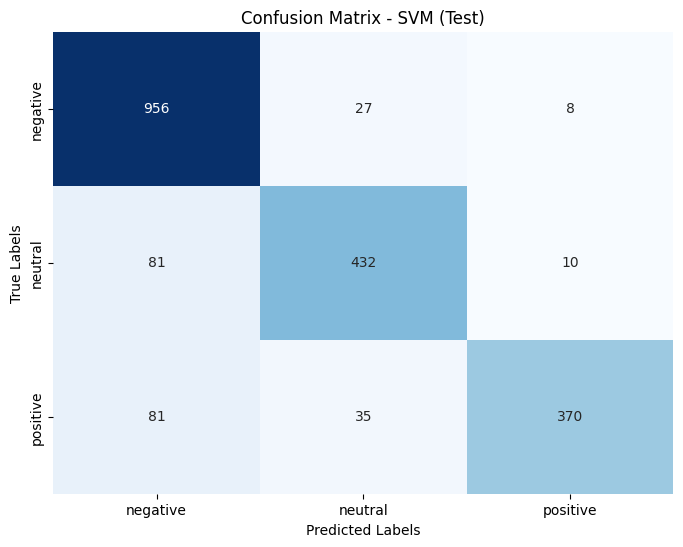

In [34]:
# Tahap Inisialisasi Model SVM
model_svm = SVC()

# Tahap Pelatihan Model SVM
model_svm.fit(X_train_tfidf, y_train)

# Tahap Prediksi Model SVM
y_pred_train_svm = model_svm.predict(X_train_tfidf)
y_pred_test_svm = model_svm.predict(X_test_tfidf)

# Tahap Evaluasi Model SVM
print("SVM Model Evaluation:")
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print(f"Training Accuracy: {accuracy_train_svm}")
print(f"Test Accuracy: {accuracy_test_svm}")
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test_svm))

# Tahap Visualisasi Confusion Matrix SVM
cm_svm = confusion_matrix(y_test, y_pred_test_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model_svm.classes_, yticklabels=model_svm.classes_)
plt.title('Confusion Matrix - SVM (Test)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 2. Logistic Regression

Logistic Regression Model Evaluation:
Training Accuracy: 0.94125
Test Accuracy: 0.8735

Classification Report (Test):
               precision    recall  f1-score   support

    negative       0.87      0.94      0.90       991
     neutral       0.82      0.85      0.84       523
    positive       0.95      0.77      0.85       486

    accuracy                           0.87      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.88      0.87      0.87      2000



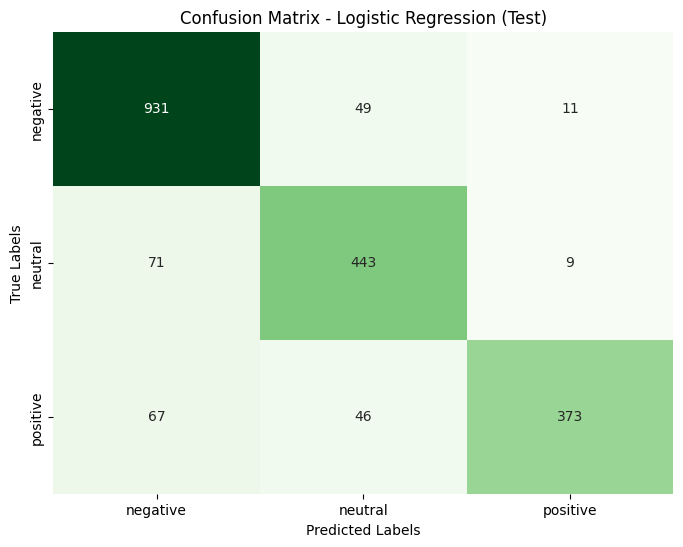

In [36]:
# Tahap Inisialisasi Model Logistic Regression
model_lr = LogisticRegression(max_iter=1000)

# Tahap Pelatihan Model Logistic Regression
model_lr.fit(X_train_tfidf, y_train)

# Tahap Prediksi Model Logistic Regression
y_pred_train_lr = model_lr.predict(X_train_tfidf)
y_pred_test_lr = model_lr.predict(X_test_tfidf)

# Tahap Evaluasi Model Logistic Regression
print("Logistic Regression Model Evaluation:")
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Training Accuracy: {accuracy_train_lr}")
print(f"Test Accuracy: {accuracy_test_lr}")
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test_lr))

# Tahap Visualisasi Confusion Matrix Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_test_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=model_lr.classes_, yticklabels=model_lr.classes_)
plt.title('Confusion Matrix - Logistic Regression (Test)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 3. Random Forest

Random Forest Model Evaluation:
Training Accuracy: 1.0
Test Accuracy: 0.8535

Classification Report (Test):
               precision    recall  f1-score   support

    negative       0.83      0.94      0.88       991
     neutral       0.86      0.87      0.86       523
    positive       0.92      0.67      0.77       486

    accuracy                           0.85      2000
   macro avg       0.87      0.82      0.84      2000
weighted avg       0.86      0.85      0.85      2000



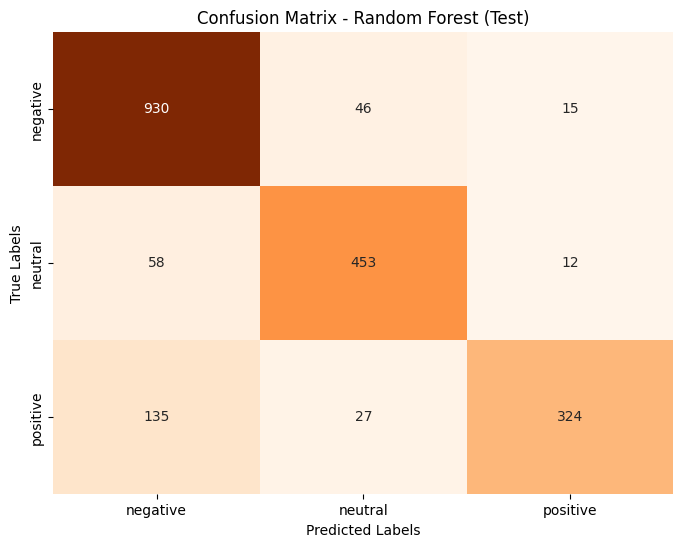

In [39]:
# Tahap Inisialisasi Model Random Forest
model_rf = RandomForestClassifier()

# Tahap Pelatihan Model Random Forest
model_rf.fit(X_train_tfidf, y_train)

# Tahap Prediksi Model Random Forest
y_pred_train_rf = model_rf.predict(X_train_tfidf)
y_pred_test_rf = model_rf.predict(X_test_tfidf)

# Tahap Evaluasi Model Random Forest
print("Random Forest Model Evaluation:")
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Training Accuracy: {accuracy_train_rf}")
print(f"Test Accuracy: {accuracy_test_rf}")
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test_rf))

# Tahap Visualisasi Confusion Matrix Random Forest
cm_rf = confusion_matrix(y_test, y_pred_test_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=model_rf.classes_, yticklabels=model_rf.classes_)
plt.title('Confusion Matrix - Random Forest (Test)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Melakukan inference atau testing

In [41]:
# prompt: Melakukan inference atau testing dalam file .ipynb atau .py yang menghasilkan output berupa kelas kategorikal (contoh: negatif, netral, dan positif).

def clean_and_preprocess_text(text):
    """
    Melakukan pembersihan, case folding, perbaikan slangword, tokenisasi,
    filtering stopword, dan stemming pada teks input.
    """
    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    tokens = tokenizingText(text)
    filtered_tokens = filteringText(tokens)
    stemmed_text = stemmingText(filtered_tokens)
    return stemmed_text

def predict_sentiment(text, vectorizer, model):
    """
    Melakukan prediksi sentimen pada teks input menggunakan vectorizer dan model yang diberikan.

    Args:
        text (str): Teks input yang akan diprediksi sentimennya.
        vectorizer: Objek vectorizer (misal: TfidfVectorizer) yang telah dilatih.
        model: Objek model klasifikasi (misal: SVC, LogisticRegression, RandomForestClassifier)
               yang telah dilatih.

    Returns:
        str: Label kelas kategorikal hasil prediksi (contoh: 'negatif', 'netral', 'positif').
    """
    # Bersihkan dan praproses teks
    processed_text = clean_and_preprocess_text(text)

    # Lakukan transformasi fitur menggunakan vectorizer yang sudah dilatih
    text_features = vectorizer.transform([processed_text])

    # Lakukan prediksi menggunakan model yang sudah dilatih
    prediction = model.predict(text_features)

    return prediction[0]

# Contoh penggunaan inference
text_to_predict = "Aplikasi netflix sangat buruk, buffering terus menerus dan seringkali error saat memutar film terbaru."

# Pilih model terbaik untuk inference, misalnya Random Forest berdasarkan evaluasi
best_model = model_rf # Atau model_svm atau model_lr tergantung hasil evaluasi

# Lakukan prediksi
predicted_sentiment = predict_sentiment(text_to_predict, tfidf, best_model)

print(f"Teks: '{text_to_predict}'")
print(f"Prediksi Sentimen: {predicted_sentiment}")

Teks: 'Aplikasi netflix sangat buruk, buffering terus menerus dan seringkali error saat memutar film terbaru.'
Prediksi Sentimen: negative


## Simpan Model

In [42]:
# Simpan Model

joblib.dump(model_svm, 'svm_model.pkl')
joblib.dump(model_lr, 'lr_model.pkl')
joblib.dump(model_rf, 'rf_model.pkl')

print("Models saved successfully.")

Models saved successfully.
